# Import libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import sklearn.metrics as mt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

# Laod dataset

In [2]:
!gdown 1BxC7U1BnapC6Sy2CJrqexQvjg4Qe_8Ac # You can download dataset from my drive

Downloading...
From: https://drive.google.com/uc?id=1BxC7U1BnapC6Sy2CJrqexQvjg4Qe_8Ac
To: /content/22_apps_flow_features.csv
100% 9.90M/9.90M [00:00<00:00, 115MB/s]


In [3]:
df = pd.read_csv('/content/22_apps_flow_features.csv')
df

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
1,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
2,192.168.72.43-10.200.7.7-55977-3128-6,192.168.72.43,55977,10.200.7.7,3128,6,26/04/201711:11:17,118415,7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,126,GOOGLE
3,192.168.180.51-10.200.7.4-57741-3128-6,10.200.7.4,3128,192.168.180.51,57741,6,26/04/201711:11:17,202151,31,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.180.51-10.200.7.4-57741-3128-6,10.200.7.4,3128,192.168.180.51,57741,6,26/04/201711:11:17,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,192.168.60.56-10.200.7.6-55742-3128-6,192.168.60.56,55742,10.200.7.6,3128,6,15/05/201705:21:54,16572953,8,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,123,GOOGLE_MAPS
17396,192.168.60.56-10.200.7.6-55744-3128-6,192.168.60.56,55744,10.200.7.6,3128,6,15/05/201705:21:54,16572649,9,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,123,GOOGLE_MAPS
17397,212.81.93.229-10.200.7.218-443-56010-6,212.81.93.229,443,10.200.7.218,56010,6,15/05/201705:17:13,55462305,7,6,...,0.0,230797.0,230797.0,55000746.0,0.0,55000746.0,55000746.0,BENIGN,148,TEAMVIEWER
17398,212.81.93.229-10.200.7.218-443-56010-6,212.81.93.229,443,10.200.7.218,56010,6,15/05/201705:19:58,55473134,6,4,...,0.0,240955.0,240955.0,55231988.0,0.0,55231988.0,55231988.0,BENIGN,148,TEAMVIEWER


# Create_dataset:
Defined a function *create_dataset()* that
- takes in input the filename of the full dataset and the names of apps (traffic flows we want to distinguish)
- selects traffic flows of the required apps
- selects the features (statistics of packet size and interarrival time)
- checks if there are flows with infinite or negative values of features
- checks for duplicate flows
- saves flows (features and labels) of the required apps in a .csv file in a subfolder called 'Features'



In [4]:
def create_dataset(filename, app_names):

# Inputs: - filename: name of the full data file to be read
#         - app_names: list with names of the apps traffic flows which we want to distinguish
# Outputs: - features file (.csv) with the dataset
#           The generated file should be put in a subfolder named "Features"

    # e.g., Min.Packet.Length = min(Fwd.Packet.Length.Min, Bwd.Packet.Length.Min)
    selected_features = [
       'Fwd.Packet.Length.Max', 'Fwd.Packet.Length.Min', 'Fwd.Packet.Length.Mean',
       'Bwd.Packet.Length.Max', 'Bwd.Packet.Length.Min', 'Bwd.Packet.Length.Mean',
       'Flow.Bytes.s',  'Flow.Packets.s',
       'Flow.IAT.Mean', 'Flow.IAT.Max', 'Flow.IAT.Min',
       'Fwd.IAT.Mean',  'Fwd.IAT.Max',  'Fwd.IAT.Min',
       'Bwd.IAT.Mean',  'Bwd.IAT.Max',  'Bwd.IAT.Min',
       'Min.Packet.Length', 'Max.Packet.Length', 'Packet.Length.Mean']

    print('Creating dataset with flows of apps {} from file {}'.format(app_names, filename))

    feature_folder = 'Features'
    if not os.path.exists(feature_folder):
        os.makedirs(feature_folder)


    df = pd.read_csv(filename, delimiter=',')



    # Filter the DataFrame based on the list of app names
    df = df[df['ProtocolName'].isin(app_names)]

    # Extract the 'ProtocolName' values into a new list
    label_list = df['ProtocolName'].to_numpy()


    df = df[selected_features] # just show columns recognized as features
    df['Label'] = label_list



    # filter out flows with unreasonable values (doesn't seem to happen)
    for feature in selected_features:
        if df[df[feature] < 0].shape[0] != 0:
            print('Feature {} has negative values in some flows').format(feature)
            df = df[df[feature] >= 0]

    # check if there are NaN, inf (doesn't seem to happen)
    if pd.isnull(df).any(axis = None): #isnull checks also infinite values
        print('There are NaN or inf values', pd.isnull(df).any(axis = None))
        df.replace([np.inf, -np.inf], np.nan, inplace=True) #there is dropna but no dropinf
        df.dropna(inplace=True)

    # check if there are duplicate rows
    if df.duplicated().any(axis = None):
        print('There are duplicated rows')
        df.drop_duplicates(inplace=True)


    df.to_csv(os.path.join(feature_folder, 'apps_flow_dataset_' + '_'.join(app_names) + '.csv'),index=False)


In [5]:
apps = ['MS_ONE_DRIVE', 'YOUTUBE'] # alternatively, you can have apps = ['SKYPE', 'DROPBOX']
create_dataset('22_apps_flow_features.csv', apps)

Creating dataset with flows of apps ['MS_ONE_DRIVE', 'YOUTUBE'] from file 22_apps_flow_features.csv
There are duplicated rows


# plot_feature_distribution:
Defined a function *plot_feature_distribution()* that
- plots distribution of the features given app names in input (one graph per feature, in each graph you should put the distribution of the feature for both apps with two different colors)
- saves the figure(s) in a subfolder called 'Figures'


In [6]:
def plot_feature_distribution(app_names):
# Input: - app_names - names of the apps traffic flows of which we want to distinguish
# Output: - plots of the distribution of each feature for 2 apps in the dataset;
#           figures should be also saved into a subfolder ("Figures")

    print('Plotting feature distribution for apps {}'.format(app_names))
    fig_folder = 'Figures'
    if not os.path.exists(fig_folder):
        os.makedirs(fig_folder)





    file_path = 'Features/apps_flow_dataset_{}.csv'.format('_'.join(app_names))

    df = pd.read_csv(file_path)


    plt.figure(figsize=(15, 60)) #F: comment if you want to have different figures
    #print('cloumns:',df.columns)

    for i, column_name in enumerate(df.columns):
        if column_name != 'Label':
            #plt.figure(figsize=(15, 100)) #F: uncomment if you want to have different figures
            ax = plt.subplot(df.columns.size, 1, i + 1)
            df.groupby('Label')[column_name].plot(kind = 'hist', alpha = 0.5, ax=ax)
            plt.title('Distribution of feature {} for classes: {} '.format(column_name, app_names))
            plt.xlabel(column_name)
            plt.legend(loc='best')
            plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

            #F: Next 3 lines in case you want to save different figures (you should also uncomment lines above)
            #plt.savefig(fig_folder + '/features_' + app_names[0] + '_' + app_names[1] + '_' + column_name + '.png', bbox_inches='tight')
            #plt.show()
            #plt.close()


    plt.savefig(os.path.join(fig_folder, 'features_' + '_'.join(app_names) + '.png'))

    #plt.close()

Plotting feature distribution for apps ['MS_ONE_DRIVE', 'YOUTUBE']


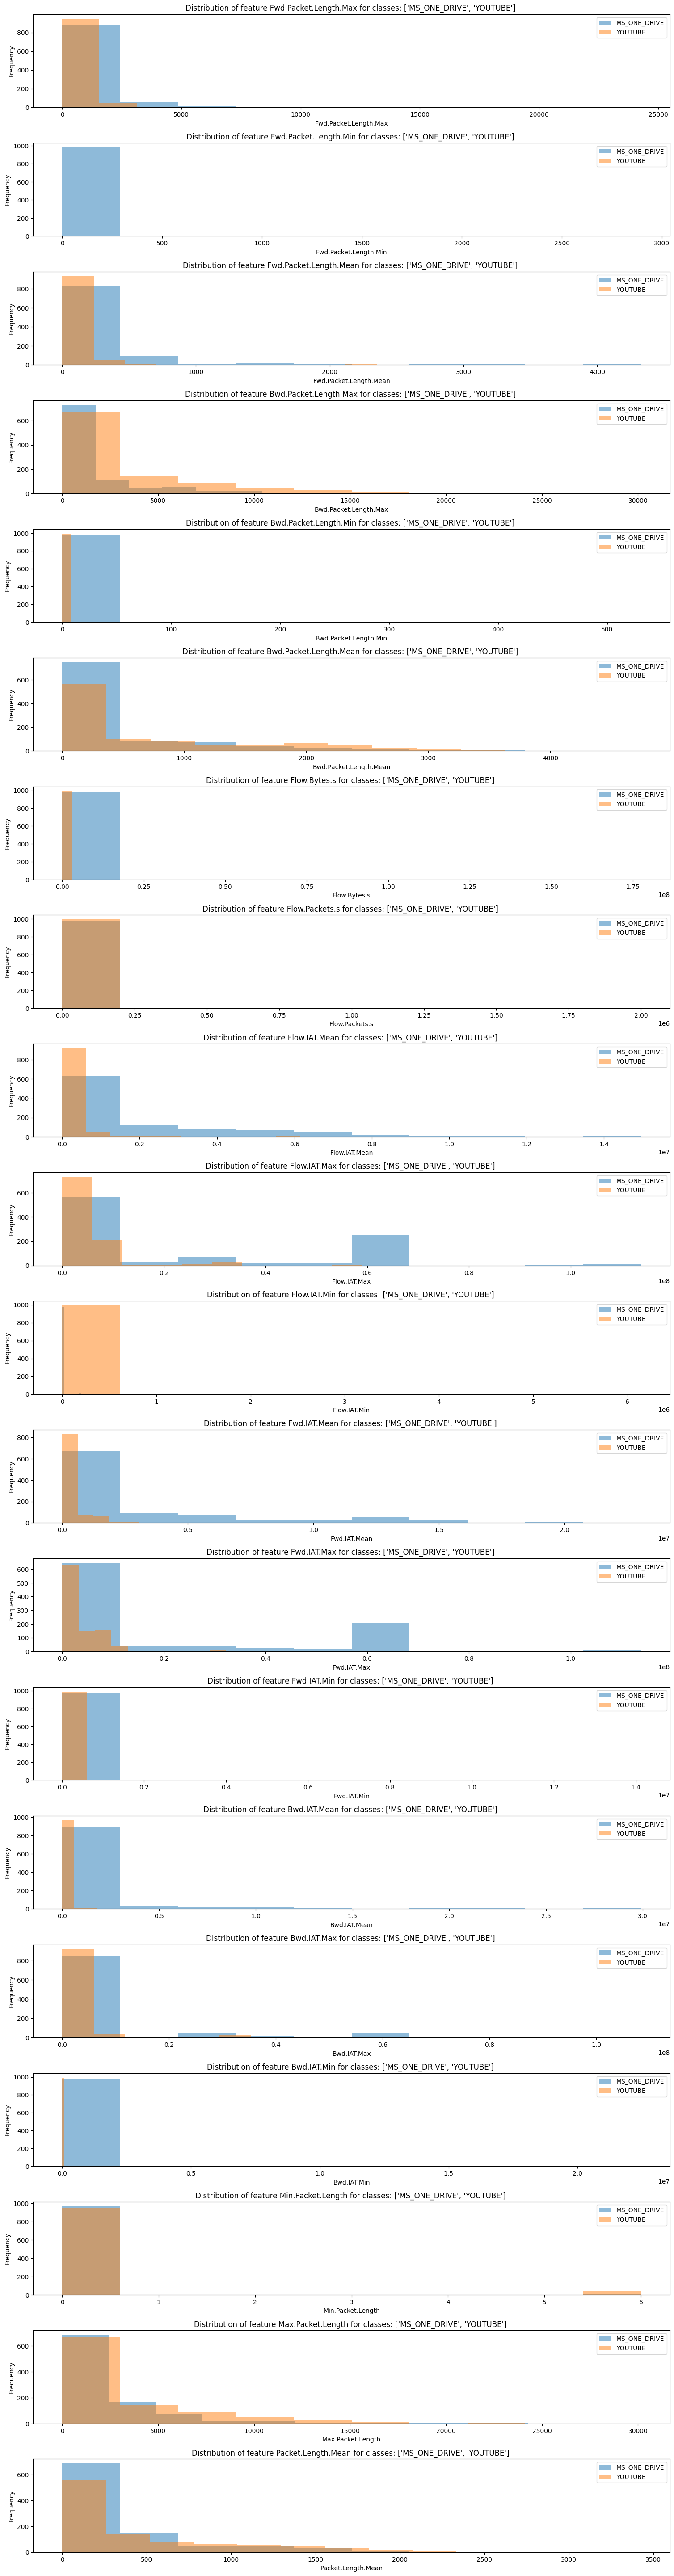

In [7]:
plot_feature_distribution(apps)

# load_dataset:
Defined a function *load_dataset()* that
- takes in input names of apps
- searches for the corresponding flow file in folder "Features"
- returns numpy arrays with features and labels


In [8]:
def load_dataset(app_names):
#Inputs: - app_names: names of the apps traffic flows of which we want to distinguish
#Outputs: - X: matrix of features retrieved from filename
#         - y: column of labels retrieved from filename


    file_path = 'Features/apps_flow_dataset_{}.csv'.format('_'.join(app_names))
    feature_df =pd.read_csv (file_path)


    label_encoder = LabelEncoder()
    feature_df['Label'] = label_encoder.fit_transform(feature_df['Label'].astype(str))




    X = feature_df.drop(columns=['Label']).to_numpy()
    y = feature_df['Label'].to_numpy()

    return X, y

In [9]:
X, y = load_dataset(apps)

print(X.shape)
print(y.shape)

(1981, 20)
(1981,)


# split dataset:
Did a 80/20 split of the dataset into train/test with balanced classes and check consistency between # of positives (i.e., datapoints with y=1) across train/test/full sets.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print('# positives in y = ' + str(np.count_nonzero(y==1)))
print('# positives in y_train = ' + str(np.count_nonzero(y_train==1)))
print('# positives in y_test = ' + str(np.count_nonzero(y_test==1)))


(1981, 20)
(1981,)
(1584, 20)
(1584,)
(397, 20)
(397,)
# positives in y = 997
# positives in y_train = 797
# positives in y_test = 200


# train_classifier_logistic
Defined function *train_classifier_logistic()* that performs hyperparameter optimization with 5-fold crossvalidation and training (details below) and returns the trained logistic regression model


In [11]:
def train_classifier_logistic(X_train, y_train, resfilelogistic):
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - resfilelogistic: full name (with path) of the results file where to put output of the training/optimization process
#This function should:
#         * Perform logistic regression hyperparameters optimization via 5-fold crossvalidation
#         * Print hyperparameters obtained with crossvalidation in resfilelogistic
#         * Retrain a logistic regression model with best hyperparameters using the entire training set (X_train, y_train)
#         * Print training results (best accuracy and training duration) in resfilelogistic
#         * Return the trained model
#
#Outputs: - updated resfilelogistic with:
#                   1) best hyperparameters obtained with crossvalidation
#                   2) best accuracy obtained during crossvalidation (for the best hyperparameters)
#                   3) duration of training over the entire training set (X_train, y_train)
#         - bestlogisticRegr: model to be returned by the function
#         - best_params: dictionary with best hyperparameters obtained with crossvalidation


    # crossvalidation
    n_split_kfold = 5
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=42)

    best_params = {'regularization': 0, 'max_iter': 0, 'score': 0}
    C_reg_range = [1, 10, 100, 1000]
    maxit_range = [1000, 5000, 10000]
    scoreplot = np.zeros([len(C_reg_range),len(maxit_range)])

    t0 = time.time()
    for i, C_reg in enumerate(C_reg_range): #loop over regularization parameter

        for j, maxit in enumerate(maxit_range): #loop over maximum iterations

            print(f'Testing hyperparameters: regularization: {C_reg}, max_iter: {maxit}')

            score = 0
            for train_index, test_index in skf.split(X_train, y_train):

                X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

                logisticRegr = LogisticRegression(C=C_reg, max_iter=maxit, random_state=42)
                logisticRegr.fit(X_train_fold, y_train_fold)
                score += logisticRegr.score(X_test_fold, y_test_fold)

            score = score / n_split_kfold
            #print('Score: '+str(score))
            scoreplot[i,j] = score

            if score > best_params['score']:
                best_params['score'] = score
                best_params['regularization'] = C_reg
                best_params['max_iter'] = maxit
                #print('New best hyperparameters!!')

    t1 = time.time()
    crossval_time = round(t1 - t0, 3)
    print('Crossval time [s]: ' + str(crossval_time))
    print('Best hyperparams during crossval: ' + str(best_params))

    print(scoreplot)

    for p in list(range(scoreplot.shape[1])):
        plt.plot(C_reg_range,scoreplot[:, p], label=f'maxiter={maxit_range[p]}')

    plt.xlabel("Regularization parameter 'C'")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    training_time = 0 #F: here you will store final training time
    finalscore = 0 #F: here you will store final accuracy

    #now retrain with best_params and using the entire training set
    #this part should produce the final model bestlogisticRegr to be returned at the end (together with best_params)
    ############# ADD YOUR CODE BELOW #############

    bestlogisticRegr = LogisticRegression(C = best_params['regularization'], max_iter = best_params['max_iter'], random_state = 42)
    t0 = time.time()
    bestlogisticRegr.fit(X_train, y_train)
    t1 = time.time()
    training_time = round(t1 - t0,3)
    finalscore = bestlogisticRegr.score(X_train, y_train)
    print('Score of the final model: ' + str(finalscore))
    print('Training time [s]: ' + str(training_time))


    ###############################################

    with open(resfilelogistic, 'w') as result_file:
        result_file.write('*** LOGISTIC REGRESSION ***\n')
        result_file.write('*** Crossvalidation results ***\n')
        result_file.write('Best C: {}\n'.format(best_params['regularization']))
        result_file.write('Best number of iterations: {}\n'.format(best_params['max_iter']))
        result_file.write('Best crossvalidation accuracy: {}\n\n'.format(best_params['score']))

        result_file.write('*** Best model results (retrained with entire training set) ***\n')
        result_file.write('Accuracy: {}\n'.format(finalscore))
        result_file.write('Training duration [s]: {}\n'.format(training_time))


    return bestlogisticRegr, best_params

Testing hyperparameters: regularization: 1, max_iter: 1000
Testing hyperparameters: regularization: 1, max_iter: 5000
Testing hyperparameters: regularization: 1, max_iter: 10000
Testing hyperparameters: regularization: 10, max_iter: 1000
Testing hyperparameters: regularization: 10, max_iter: 5000
Testing hyperparameters: regularization: 10, max_iter: 10000
Testing hyperparameters: regularization: 100, max_iter: 1000
Testing hyperparameters: regularization: 100, max_iter: 5000
Testing hyperparameters: regularization: 100, max_iter: 10000
Testing hyperparameters: regularization: 1000, max_iter: 1000
Testing hyperparameters: regularization: 1000, max_iter: 5000
Testing hyperparameters: regularization: 1000, max_iter: 10000
Crossval time [s]: 55.408
Best hyperparams during crossval: {'regularization': 1000, 'max_iter': 1000, 'score': 0.7203070718364413}
[[0.70768678 0.70768878 0.70768878]
 [0.71273809 0.70831969 0.70831969]
 [0.69696522 0.70958152 0.70958152]
 [0.72030707 0.71021243 0.7102

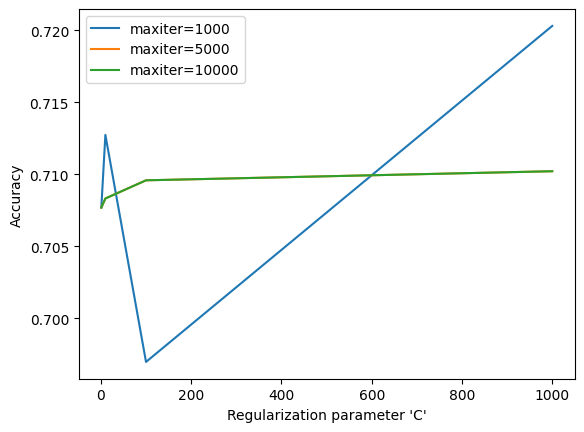

Score of the final model: 0.7184343434343434
Training time [s]: 1.133


In [12]:
# Run and save results
res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)
resf = res_folder + '/testlogregr_results.txt'
logreg, best_params_logreg = train_classifier_logistic(X_train, y_train, resf)

# Standardization:
Considered a new dataset (X_std, y) instead of (X,y) with **standardized** features and repeat train/test split and hyperparameters selection with crossvalidation with the standardized dataset.


(1584, 20)
(1584,)
(397, 20)
(397,)
Testing hyperparameters: regularization: 1, max_iter: 1000
Testing hyperparameters: regularization: 1, max_iter: 5000
Testing hyperparameters: regularization: 1, max_iter: 10000
Testing hyperparameters: regularization: 10, max_iter: 1000
Testing hyperparameters: regularization: 10, max_iter: 5000
Testing hyperparameters: regularization: 10, max_iter: 10000
Testing hyperparameters: regularization: 100, max_iter: 1000
Testing hyperparameters: regularization: 100, max_iter: 5000
Testing hyperparameters: regularization: 100, max_iter: 10000
Testing hyperparameters: regularization: 1000, max_iter: 1000
Testing hyperparameters: regularization: 1000, max_iter: 5000
Testing hyperparameters: regularization: 1000, max_iter: 10000
Crossval time [s]: 3.394
Best hyperparams during crossval: {'regularization': 1000, 'max_iter': 1000, 'score': 0.7323783093079903}
[[0.70390129 0.70390129 0.70390129]
 [0.70770275 0.70770275 0.70770275]
 [0.7209899  0.7209899  0.72098

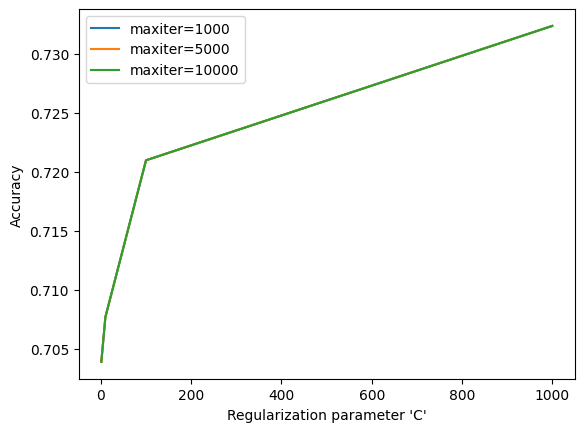

Score of the final model: 0.726010101010101
Training time [s]: 0.085


In [13]:

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print(X_train_std.shape)
print(y_train.shape)
print(X_test_std.shape)
print(y_test.shape)

res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)
resf=res_folder + '/testlogregr_results_STD.txt'
logreg_std, best_params_logreg_std = train_classifier_logistic(X_train_std, y_train, resf)

# train_classifier_XGB:
Defined function *train_classifier_XGB()* that performs hyperparameter optimization and training for XGB with given hyperparameters space (details below)


In [14]:
def train_classifier_XGB(X_train, y_train, resfileXGB):
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - resfileXGB: full name (with path) of the results file where to put output of the training/optimization process
#This function should:
#         * Perform XGB hyperparameters optimization via 5-fold crossvalidation
#         * Print hyperparameters obtained with crossvalidation in resfileXGB
#         * Retrain a XGB model with best hyperparameters using the entire training set (X_train, y_train)
#         * Print training results (best accuracy and training duration) in resfileXGB
#         * Return the trained model
#
#Outputs: - updated resfileXGB with:
#                   1) best hyperparameters obtained with crossvalidation
#                   2) best accuracy obtained during crossvalidation (for the best hyperparameters)
#                   3) duration of training over the entire training set (X_train, y_train)
#         - bestXGB: model to be returned by the function
#         - best_params: dictionary with best hyperparameters obtained with crossvalidation
############# ADD YOUR CODE BELOW #############


    # crossvalidation
    n_split_kfold = 5
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=42)

    best_params = {'n_estimators': 0, 'max_depth': 0, 'subsample': 0, 'score': 0}
    num_estimators_range = [25, 50, 100]
    max_depth_range = [5, 20, 50]
    subsample_range = [0.7, 0.9, 1]

    scoreplot = np.zeros([len(num_estimators_range), len(max_depth_range), len(subsample_range)])

    t0 = time.time()
    for i, n_est in enumerate(num_estimators_range): #loop over num_estimators
        for j, max_dep in enumerate(max_depth_range): #loop over max_depth
            for k, subsamp in enumerate(subsample_range): #loop subsample

                print(f'Testing hyperparameters: n_estimators: {n_est}, max_depth: {max_dep}, subsample: {subsamp}')
                score = 0
                for train_index, test_index in skf.split(X_train, y_train):
                    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

                    xgb = XGBClassifier(verbosity = 0, objective = 'binary:logistic', eval_metric=['error', 'logloss'],
                                          n_estimators = n_est, max_depth = max_dep, subsample = subsamp)

                    xgb.fit(X_train_fold, y_train_fold)
                    score += xgb.score(X_test_fold, y_test_fold)

                score = score / n_split_kfold
                #print('Score: '+str(score))
                scoreplot[i, j, k] = score

                if score > best_params['score']:
                    best_params['score'] = score
                    best_params['n_estimators'] = n_est
                    best_params['max_depth'] = max_dep
                    best_params['subsample'] = subsamp
                    #print('New best hyperparameters!!')
    t1 = time.time()
    crossval_time = round(t1 - t0,3)
    print('Crossval time [s]: ' + str(crossval_time))
    print('Best hyperparams: ' + str(best_params))

    print(scoreplot)
    #print(scoreplot.shape)

    for p in list(range(scoreplot.shape[0])):
        for q in list(range(scoreplot.shape[1])):
            #print('p,q: ' + str(p)+str(q))
            plt.plot(subsample_range, scoreplot[p,q,:], label=f'n_est={num_estimators_range[p]} - max_dep={max_depth_range[q]} ')

    plt.xlabel("Subsample")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    #now retrain with best_params and using the entire training set
    bestxgb = XGBClassifier(verbosity = 0, objective = 'binary:logistic', eval_metric=['error', 'logloss'],
                                          n_estimators = best_params['n_estimators'],
                                          max_depth = best_params['max_depth'],
                                          subsample = best_params['subsample'])

    t0 = time.time()
    bestxgb.fit(X_train, y_train)
    t1 = time.time()
    training_time = round(t1-t0,3)
    finalscore = bestxgb.score(X_train, y_train)
    print('Score of the final model: ' + str(finalscore))
    print(f'Best n_estimators: {best_params["n_estimators"]}.')
    print(f'Best max_depth: {best_params["max_depth"]}.')
    print(f'Best subsample: {best_params["subsample"]}')
    print('Training time [s]: ' + str(training_time))


    ###############################################

    with open(resfileXGB, 'w') as result_file:
        result_file.write('*** XGB ***\n')
        result_file.write('*** Crossvalidation results ***\n')
        result_file.write('Best n_estimators: {}\n'.format(best_params['n_estimators']))
        result_file.write('Best max_depth: {}\n'.format(best_params['max_depth']))
        result_file.write('Best subsample: {}\n'.format(best_params['subsample']))
        result_file.write('Best crossvalidation accuracy: {}\n\n'.format(best_params['score']))

        result_file.write('*** Best model results (retrained with entire training set) ***\n')
        result_file.write('Accuracy: {}\n'.format(finalscore))
        result_file.write('Training duration [s]: {}\n'.format(training_time))

    return bestxgb, best_params

Testing hyperparameters: n_estimators: 25, max_depth: 5, subsample: 0.7
Testing hyperparameters: n_estimators: 25, max_depth: 5, subsample: 0.9
Testing hyperparameters: n_estimators: 25, max_depth: 5, subsample: 1
Testing hyperparameters: n_estimators: 25, max_depth: 20, subsample: 0.7
Testing hyperparameters: n_estimators: 25, max_depth: 20, subsample: 0.9
Testing hyperparameters: n_estimators: 25, max_depth: 20, subsample: 1
Testing hyperparameters: n_estimators: 25, max_depth: 50, subsample: 0.7
Testing hyperparameters: n_estimators: 25, max_depth: 50, subsample: 0.9
Testing hyperparameters: n_estimators: 25, max_depth: 50, subsample: 1
Testing hyperparameters: n_estimators: 50, max_depth: 5, subsample: 0.7
Testing hyperparameters: n_estimators: 50, max_depth: 5, subsample: 0.9
Testing hyperparameters: n_estimators: 50, max_depth: 5, subsample: 1
Testing hyperparameters: n_estimators: 50, max_depth: 20, subsample: 0.7
Testing hyperparameters: n_estimators: 50, max_depth: 20, subsamp

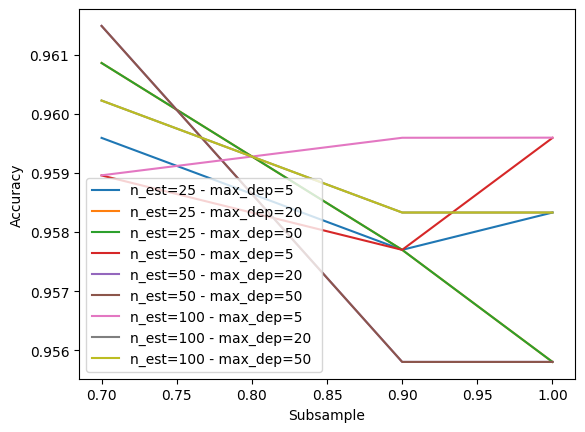

Score of the final model: 0.9962121212121212
Best n_estimators: 50.
Best max_depth: 20.
Best subsample: 0.7
Training time [s]: 0.13


In [15]:
res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)
resf=res_folder + '/testXGB_results.txt'
XGB, best_params_XGB = train_classifier_XGB(X_train, y_train, resf)

# performance_eval:
Defined function *performance_eval()* that takes in input ground truth and predicted labels, prints results in a result file passed in input, and returns global metrics (details below)


In [16]:
def performance_eval(y_true, y_pred, lab, l_names, resfile):
#Inputs: - y_true: ground-truth labels
#        - y_pred: predicted labels
#        - lab: list of labels (integers) as used during training phase
#        - l_names: list of labels (categories) corresponding to integer labels "lab";
#                   can be customized, it's only used for results plotting
#        - resfile: full name (with path) of the results file where to put performance metrics
#This function should:
#         * Compute Accuracy, Precision (global-weighted and per class), Recall (global-weighted and per class), F1-score (global-weighted and per class)
#         * Write them in result .txt file (resfile passed in input)
#         * Compute confusion matrix (cm) and save it in the same result .txt file (resfile)
#         * Return Accuracy, overall Precision, overall Recall, overall F1-score
#         * Plot of the cm is already given in the code (you need to call the confusion matrix objects as cm and cm_norm)
#Outputs: - updated resfileXGB with:
#                              1) Accuracy, Precision (global-weighted and per class), Recall (global-weighted and per class), F1-score (global-weighted and per class)
#                              2) Confusion matrix (cm) and confusion matrix normalized wrt true labels (cm_norm)
#         - return accuracy, global_precision, global_recall, global_f1score (use these variable names!)


    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true,y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None)
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted')
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted')
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')
    cm = confusion_matrix(y_true,y_pred)
    cm_norm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]


########################################################################
    with open(resfile, 'w') as result_file:
        result_file.write('Results for the TEST SET\n')
        result_file.write('Accuracy: {}\n'.format(accuracy))
        result_file.write('Precision per class: {}\n'.format(precision))
        result_file.write('Global Precision: {}\n'.format(global_precision))
        result_file.write('Recall per class: {}\n'.format(recall))
        result_file.write('Global Recall: {}\n'.format(global_recall))
        result_file.write('F1-score: {}\n'.format(f1score))
        result_file.write('Global F1-score: {}\n'.format(global_f1score))

        result_file.write('\nConfusion matrix, without normalization\n')
        np.savetxt(result_file, cm, fmt = '%.2f')

        result_file.write('\nNormalized confusion matrix\n')
        #np.savetxt(result_file, cm_norm, fmt = '%.2f')
        result_file.write(str(cm_norm))



#F: in the following, we plot the confusion matrices (absolute and normalized one)
# ------------------------------- absolute -------------------------------
        title = 'Confusion matrix'
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               #xticklabels=lab, yticklabels=lab,
               xticklabels=l_names, yticklabels=l_names,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions (#F: i.e., cells in the confusion matrix) and create text annotations.
        fmt = 'd'
        thresh = cm.max() / 2.
        for w in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, w, format(cm[w, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[w, j] > thresh else "black")
        fig.tight_layout()
        fig.savefig(resfile.replace('.txt','_conf_matrix.png'))
        plt.show()
# ------------------------------- normalized -------------------------------
        title_norm = 'Normalized confusion matrix'
        fig_n, ax_n = plt.subplots()
        im = ax_n.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
        ax_n.figure.colorbar(im, ax=ax_n)
        # We want to show all ticks...
        ax_n.set(xticks=np.arange(cm_norm.shape[1]),
               yticks=np.arange(cm_norm.shape[0]),
               # ... and label them with the respective list entries
               #xticklabels=lab, yticklabels=lab,
               xticklabels=l_names, yticklabels=l_names,
               title=title_norm,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions (#F: i.e., cells in the confusion matrix) and create text annotations.
        fmt = '.2f'
        thresh = cm_norm.max() / 2.
        for w in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                ax_n.text(j, w, format(cm_norm[w, j], fmt),
                        ha="center", va="center",
                        color="white" if cm_norm[w, j] > thresh else "black")
        fig_n.tight_layout()
        fig_n.savefig(resfile.replace('.txt','_conf_matrix_normalized.png'))
        plt.show()

# Now we return the global metrics (Accuracy, Precision, Recall, F1-score) calculated above

    return accuracy, global_precision, global_recall, global_f1score


************** LOGISTIC REGRESSION **************


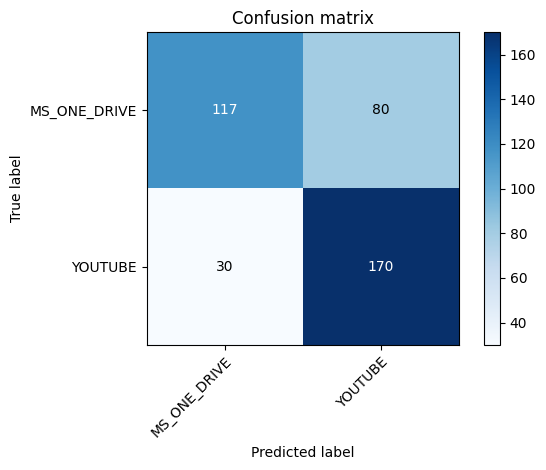

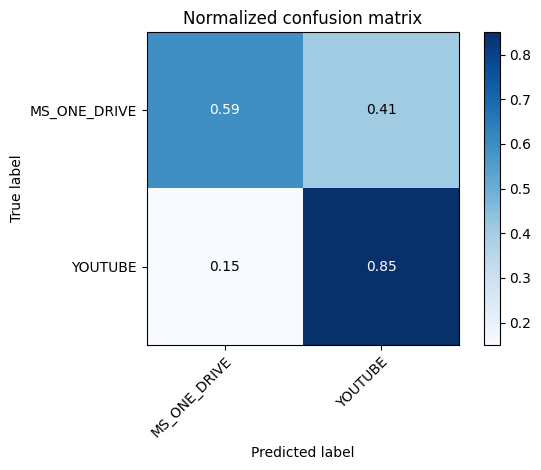

Logistic regression metrics (accuracy, global precision, global recall, global f1score): (0.7229219143576826, 0.7375212049555339, 0.7229219143576826, 0.7181786525556663)
**************************************************


************** XGB **************


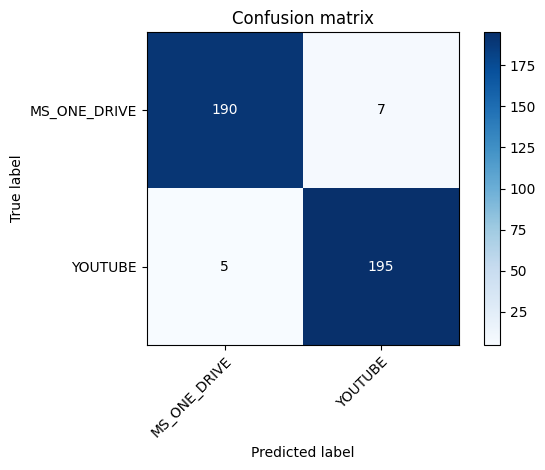

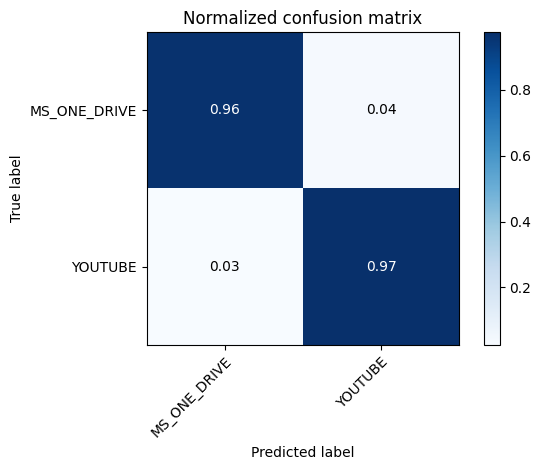

XGB metrics (accuracy, global precision, global recall, global f1score): (0.9697732997481109, 0.9698187024670303, 0.9697732997481109, 0.9697713816155433)


In [17]:
#file names to pass as input to performance_eval()
restestfilelogreg = res_folder + '/logreg_test_results.txt'
restestfileXGB = res_folder + '/XGB_test_results.txt'

lbl = [0, 1]
label_names=apps #label names to use as inputs to performance_eval()
############# ADD YOUR CODE BELOW #############
y_pred_logreg = logreg_std.predict(X_test_std)
y_pred_XGB = XGB.predict(X_test)

print('************** LOGISTIC REGRESSION **************')
logreg_metrics = performance_eval(y_test, y_pred_logreg, lbl, label_names, restestfilelogreg)
print('Logistic regression metrics (accuracy, global precision, global recall, global f1score): ' +str(logreg_metrics))
print('**************************************************\n\n')

print('************** XGB **************')
XGB_metrics = performance_eval(y_test, y_pred_XGB, lbl, label_names, restestfileXGB)
print('XGB metrics (accuracy, global precision, global recall, global f1score): ' +str(XGB_metrics))





# PCA visualization

Did a transformation with PCA and 2 components, we are able to visualize data on a 2D graph

(code already given below)


In [18]:
#F: We apply PCA to transform feature space into a 2D features space, so that we can plot on a 2D graph
from sklearn.decomposition import PCA

#app_one = 'MS_ONE_DRIVE'
#app_two = 'YOUTUBE'
#apps = [app_one, app_two]

#create_dataset('22_apps_flow_features.csv', apps)
#X, y = load_dataset(apps)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_std)
X_new = pca.transform(X_std)


print('--------------------')
print(X.shape) #F: size of the original features space
print(X_new.shape) #F: size of the PCA-transformed 2D features space
print(X_new) #F: new features


--------------------
(1981, 20)
(1981, 2)
[[ 0.29452973 -1.70392445]
 [-0.44628433 -1.08902902]
 [ 0.4087868  -1.8666989 ]
 ...
 [ 2.79016938  2.01817609]
 [ 2.73341912  2.06657484]
 [ 0.41213601 -1.91670723]]


In [19]:
#F: We create new arrays, each including data points of one scenario only (either A, B)....
xnewA = [X_new[i,:] for i in range(X_new.shape[0]) if y[i]==0]
xnewB = [X_new[i,:] for i in range(X_new.shape[0]) if y[i]==1]

In [20]:
#F: ... and transform them in lists, splitting the two components of each data point, one per list (for drawing purposes)
xA=[xnewA[i][0] for i in range(len(xnewA))]
yA=[xnewA[i][1] for i in range(len(xnewA))]
xB=[xnewB[i][0] for i in range(len(xnewB))]
yB=[xnewB[i][1] for i in range(len(xnewB))]

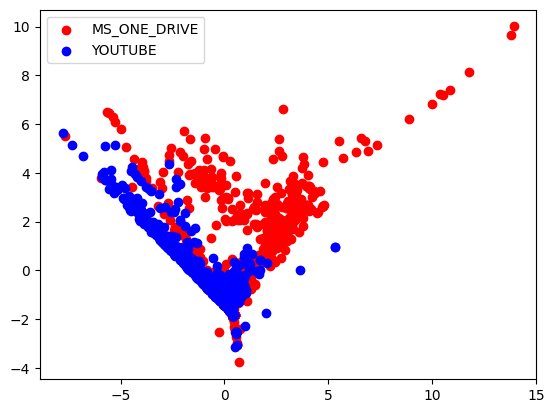

In [21]:
#F: Finally, we visualize the 2 sets of data points (2 classes) with 2 different colors
A=plt.scatter(xA,yA,c='red')
B=plt.scatter(xB,yB,c='blue')
plt.legend((A,B),(apps[0],apps[1]), loc='best')